# HMMs for Pairs Trading

Does it have an Abstract, Introduction, Body, and Conclusion?

Are the graphs and diagrams labeled?

## Abstract

In our project, we use hidden Markov models (HMMs) to predict stock values using [XYZ] as observation data. We then conduct time-series analysis using the mean reversion strategy to select pairs to trade based on those predicted values. Our model performs [HOW WELL].

## Introduction

NAmes

In [1]:
import numpy as np
import pandas as pd
import statsmodels
import seaborn as sns
from statsmodels.tsa.stattools import coint

import matplotlib.pyplot as plt

/Users/tutrinh/opt/anaconda3/envs/env_full/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Stock_values will be the predicted stock values in a dataframe, dates as indices and ticks as columns

def find_cointegrated_pairs(stock_values):
    n = stock_values.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = stock_values.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = stock_values[keys[i]]
            S2 = stock_values[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [5]:
# from backtester.dataSource.yahoo_data_source import YahooStockDataSource
# from datetime import datetime

# startDateStr = '2007/12/01'
# endDateStr = '2017/12/01'
# cachedFolderName = 'yahooData/'
# dataSetId = 'testPairsTrading'
# instrumentIds = ['SPY','AAPL','ADBE','EBAY','MSFT','QCOM',
#                  'HPQ','JNPR','AMD','IBM']
# ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
#                             dataSetId=dataSetId,
#                             instrumentIds=instrumentIds,
#                             startDateStr=startDateStr,
#                             endDateStr=endDateStr,
#                             event='history')
# data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: SPY
Processing data for stock: AAPL
Processing data for stock: ADBE
Processing data for stock: EBAY
Processing data for stock: MSFT
Processing data for stock: QCOM
Processing data for stock: HPQ
Processing data for stock: JNPR
Processing data for stock: AMD
Processing data for stock: IBM
20% done...
40% done...
60% done...
80% done...


In [20]:
# Heatmap

def heatmap(stock_values):
    scores, pvalues, pairs = find_cointegrated_pairs(stock_values)
    sns.heatmap(pvalues, xticklabels = instrumentIds, yticklabels = instrumentIds,
                cmap='mako', mask = (pvalues >= 0.98))
    plt.show()
    print(pairs)

0.0017888061236893454


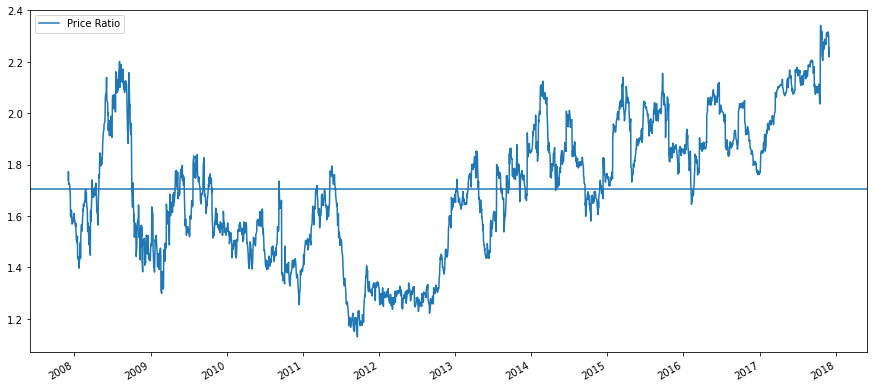

In [7]:
# Straight line: mean, moving line: price ratio

S1 = data['ADBE']
S2 = data['MSFT']
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

In [8]:
def zscore(arr):
    return (arr - arr.mean()) / np.std(arr)

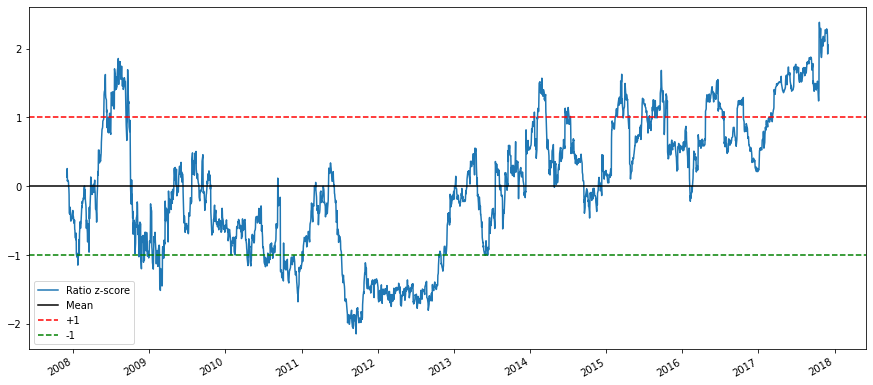

In [9]:
# Plotting z-score lines
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

In [10]:
# Split into train and test
# CODE HERE

2518


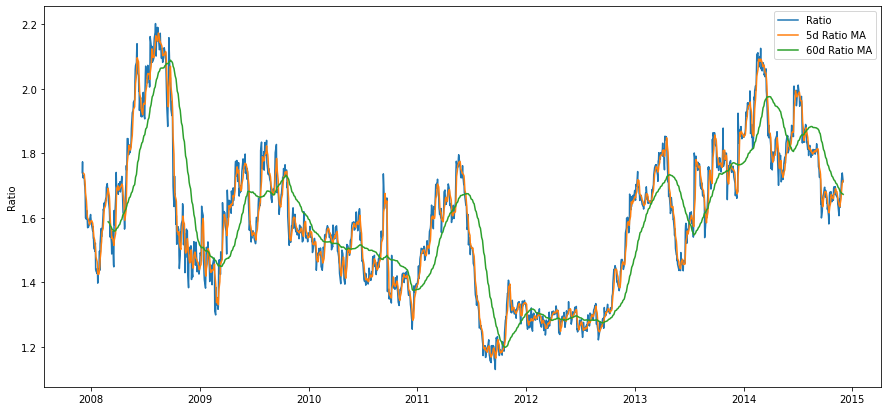

In [11]:
# let's use 5d Moving Average to compute to z score
# 60d Moving Average and 60d Standard Deviation as the mean and standard deviation
ratios_mavg5 = train.rolling(window = 5, center = False).mean()
ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()

std_60 = train.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

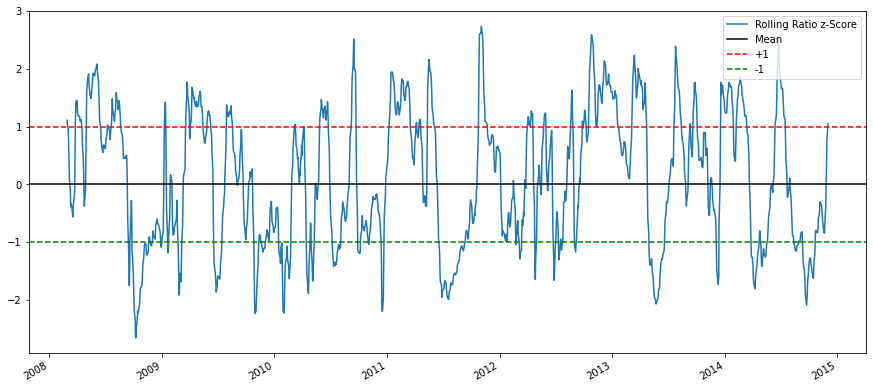

In [12]:
# Take a rolling 60 day standard deviation
std_60 = train.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

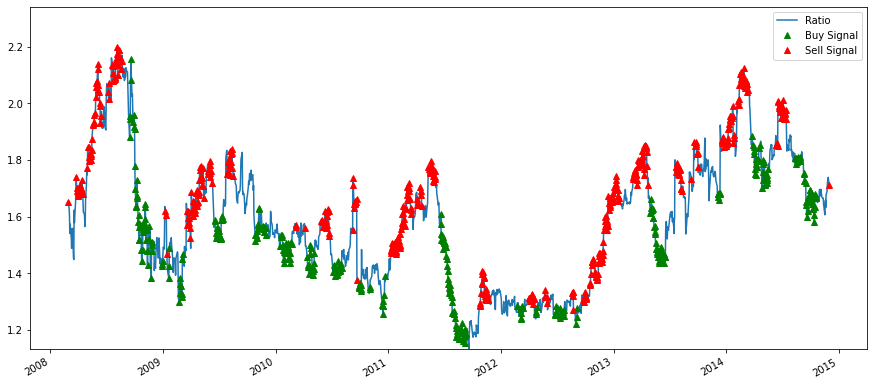

In [13]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

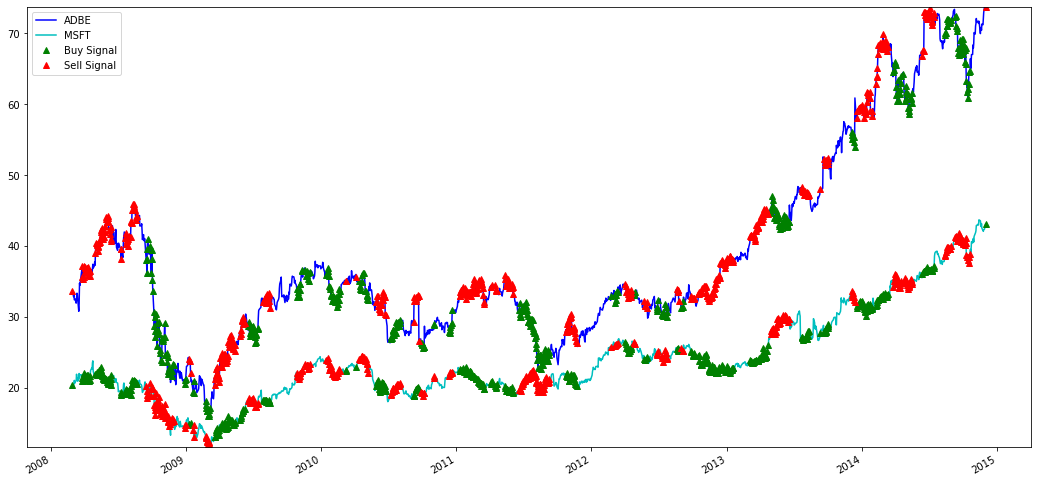

In [14]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = data['ADBE'].iloc[:1762]
S2 = data['MSFT'].iloc[:1762]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['ADBE','MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

In [15]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
    return money


trade(data['ADBE'].iloc[:1762], data['MSFT'].iloc[:1762], 5, 60)

629.7084156768401

The strategy seems profitable! Now we can optimize further by changing our moving average windows, by changing the thresholds for buy/sell and exit positions etc and check for performance improvements on validation data. We could also try more sophisticated models like Logistic Regression, SVM etc to make our 1/-1 predictions.

In [16]:
# Trade
trade(data['ADBE'].iloc[1762:], data['MSFT'].iloc[1762:], 5, 90)

1177.366847718848

In [17]:
# Grid search sorta for best window length
# Find the window length 0-254 
# that gives the highest returns using this strategy
length_scores = [trade(data['ADBE'].iloc[:1762], 
                data['MSFT'].iloc[:1762], 5, l) 
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

Best window length: 246


In [18]:
# Find the returns for test data
# using what we think is the best window length
length_scores2 = [trade(data['ADBE'].iloc[1762:], 
                  data['MSFT'].iloc[1762:],5, l) 
                  for l in range(255)]
print (best_length, 'day window:', length_scores2[best_length])

# Find the best window length based on this dataset, 
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

246 day window: 987.0053586062376
191 day window: 1572.1955287583803


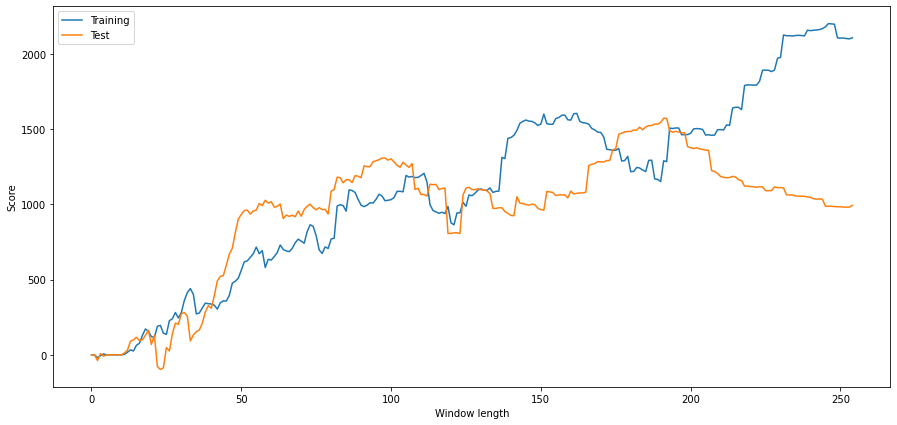

In [19]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()